In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
import glob
import xarray as xr

inpath = "/work/uo1227/u301557/DL/data/"
sia_files = glob.glob(f"{inpath}/sia/*r1*_hist_ssp585*")
sia = xr.open_dataset(sia_files[0])

sia_files = glob.glob(f"{inpath}/sia/*r2*_hist_ssp585*")
sia2 = xr.open_dataset(sia_files[0])

co2 = xr.open_dataset(f"{inpath}/co2_emissions.nc")

sst_files = glob.glob(f"{inpath}/sst/*r1*_hist_ssp585*")
sst = xr.open_dataset(sst_files[0])

gmst_files = glob.glob(f"{inpath}/gmst/*r1*_hist_ssp585*")
gmst = xr.open_dataset(gmst_files[0])

In [24]:
#co2_emissions = co2.ssp585.cumsum().values[100:]
co2_emissions = gmst.tas.isel(time=slice(8,-1,12)).values[:]
sea_ice_area  = sia.sia_nh.isel(time=slice(8,-1,12)).values[:]

In [25]:
print(co2_emissions.shape,sea_ice_area.shape)

(251, 1, 1) (251,)


In [33]:
# Define your training and testing data
# Assuming you have CO2 emissions and sea ice area measurements for the entire period

# Data from 1850 to 2014 (training data)
train_co2_emissions = co2_emissions[:165]
train_sea_ice_area = sea_ice_area[:165]
train_sia_max = np.max(train_sea_ice_area)
train_co2_max = np.max(train_co2_emissions)

# Data from 2015 to 2100 (testing data)
test_co2_emissions = co2_emissions[165:]
test_sea_ice_area = sea_ice_area[165:]
test_co2_max = np.max(test_co2_emissions)

# Normalize the training and testing data
train_co2 = np.array(train_co2_emissions) / test_co2_max
train_sia = np.array(train_sea_ice_area) / train_sia_max
test_co2 = np.array(test_co2_emissions) / test_co2_max  # Normalize with respect to training data
test_sia = np.array(test_sea_ice_area) / train_sia_max

# Convert the data to PyTorch tensors
train_co2_emissions = torch.tensor(train_co2, dtype=torch.float32).view(-1, 1, 1)  # [seq_len, batch_size, input_size]
train_sia = torch.tensor(train_sia, dtype=torch.float32).view(-1, 1)  # [seq_len, output_size]
test_co2_emissions = torch.tensor(test_co2, dtype=torch.float32).view(-1, 1, 1)  # [seq_len, batch_size, input_size]
test_sia = torch.tensor(test_sia, dtype=torch.float32).view(-1, 1)

In [27]:
train_co2_emissions.shape,train_sia.shape, test_co2_emissions.shape

(torch.Size([165, 1, 1]), torch.Size([165, 1]), torch.Size([86, 1, 1]))

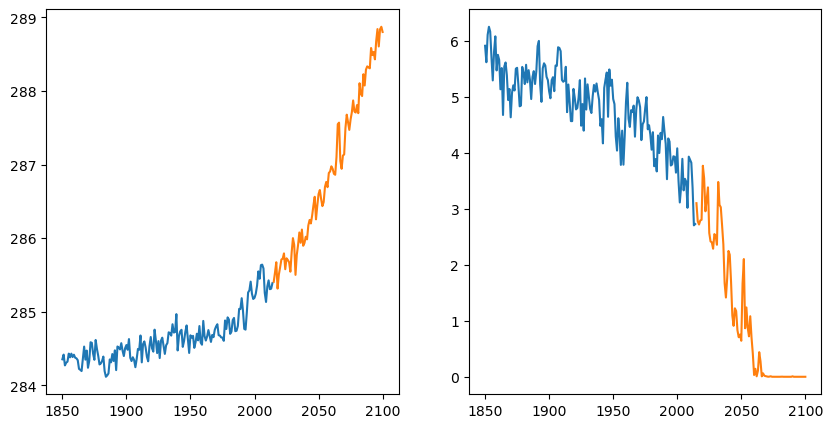

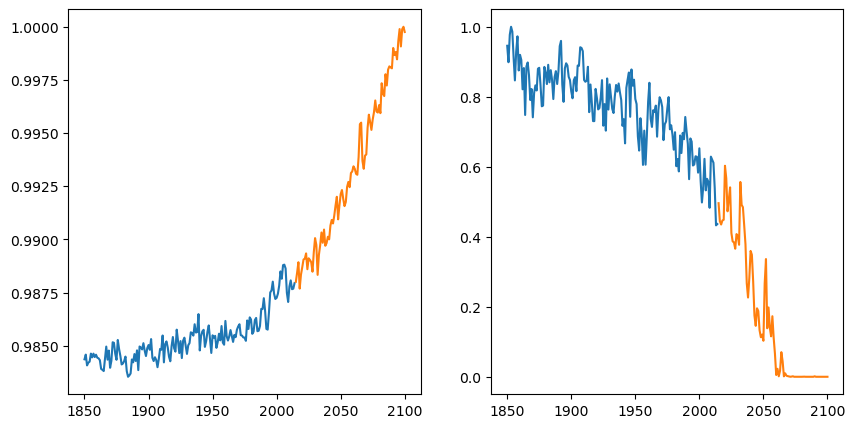

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax1,ax2 = fig.subplots(1,2)
ax1.plot(range(1850,2015),torch.squeeze(train_co2_emissions)*train_co2_max)
ax1.plot(range(2015,2101),torch.squeeze(test_co2_emissions)*train_co2_max)
ax2.plot(range(1850,2015),torch.squeeze(train_sia)*train_sia_max)
ax2.plot(range(2015,2101),test_sea_ice_area)

fig = plt.figure(figsize=(10,5))
ax1,ax2 = fig.subplots(1,2)
ax1.plot(range(1850,2015),torch.squeeze(train_co2_emissions))
ax1.plot(range(2015,2101),torch.squeeze(test_co2_emissions))
ax2.plot(range(1850,2015),torch.squeeze(train_sia))
ax2.plot(range(2015,2101),test_sea_ice_area/train_sia_max)

In [29]:
# Define your LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        output, _ = self.lstm(input)
        output = self.fc(output[-1])  # Use the output of the last time step
        return output

In [35]:
def create_sequences2(x,y, sliding_window):
    inout_seq = []
    L = len(x)
    for i in range(L-sliding_window):
        
        seq_input = x[i:i+sliding_window]
        
        seq_output = y[i+sliding_window:i+sliding_window+1]
        inout_seq.append((seq_input ,seq_output))
    return inout_seq

In [38]:
sliding_window = 10
Train_inout_seq = create_sequences2(train_co2_emissions,train_sia, sliding_window)
Test_inout_seq  = create_sequences2(test_co2_emissions, test_sia, sliding_window)

print(Train_inout_seq[:1])

[(tensor([[[0.9844]],

        [[0.9846]],

        [[0.9841]],

        [[0.9842]],

        [[0.9843]],

        [[0.9846]],

        [[0.9845]],

        [[0.9846]],

        [[0.9845]],

        [[0.9846]]]), tensor([[0.9198]]))]


In [41]:
#Preparing the data for the network
from torch.utils.data import Dataset, DataLoader
class timeseries(Dataset):
    def __init__(self,seq):
        self.seq = seq
    def __getitem__(self,idx):
        x , y = self.seq[idx]
        return torch.tensor(x,dtype=torch.float32), torch.tensor(y,dtype=torch.float32)
    def __len__(self):
        return len(self.seq)

dataset = timeseries(Train_inout_seq)
train_loader = DataLoader(dataset,shuffle=True,batch_size=32)

In [30]:
# Set hyperparameters
input_size = 1
hidden_size = 64
output_size = 1
num_epochs = 100
learning_rate = 0.001


In [103]:
# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = model(train_co2_emissions)
    loss = criterion(output, train_sia)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([165, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.5003
Epoch [20/100], Loss: 0.0598
Epoch [30/100], Loss: 0.0134
Epoch [40/100], Loss: 0.0215
Epoch [50/100], Loss: 0.0167
Epoch [60/100], Loss: 0.0136
Epoch [70/100], Loss: 0.0133
Epoch [80/100], Loss: 0.0134
Epoch [90/100], Loss: 0.0133
Epoch [100/100], Loss: 0.0133


In [32]:
# Create the LSTM model
model = LSTMModel(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

w = 10
for epoch in range(num_epochs):
    # Forward pass
    for t in range(len(train_co2_emissions)-w):
        output = model(train_co2_emissions[t:t+w])
        print()
        loss = criterion(output, train_sia[t+w])

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.0147
Epoch [20/100], Loss: 0.0199
Epoch [30/100], Loss: 0.0247
Epoch [40/100], Loss: 0.0271
Epoch [50/100], Loss: 0.0336
Epoch [60/100], Loss: 0.0390
Epoch [70/100], Loss: 0.0419
Epoch [80/100], Loss: 0.0440
Epoch [90/100], Loss: 0.0468
Epoch [100/100], Loss: 0.0490


In [22]:
# Predict the sea ice area for the test data
predicted_sea_ice_area = []

# Initialize the initial input with the last training data point
input_data = train_co2_emissions[-1].unsqueeze(0)

# Iterate over the test CO2 emissions data and predict the sea ice area for each year
for i in range(len(test_co2_emissions)):
    output = model(input_data)
    predicted_sea_ice_area.append(output.item())

    # Prepare the input for the next time step
    input_data = torch.tensor([[test_co2_emissions[i]]], dtype=torch.float32)

# De-normalize the predicted sea ice area
predicted_sea_ice_area = np.array(predicted_sea_ice_area) * train_sia_max

#print("Predicted sea ice area:", predicted_sea_ice_area)

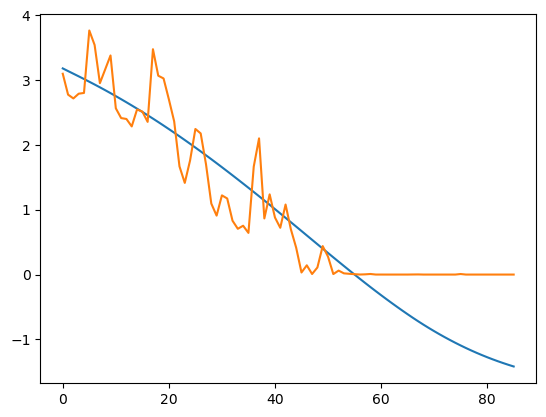

In [23]:
import matplotlib.pyplot as plt
plt.plot(predicted_sea_ice_area)
plt.plot(test_sea_ice_area)